# <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Measuring Model P&L</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [6]:
import pandas as pd
import numpy as np

In [2]:
url = (
    "https://drive.google.com/file/d/1yIrpcY2N3CFn98t40NA7OZEtNq0g27_k/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

In [3]:
dataset["ead"] = dataset[["balance", "loan_amount"]].max(axis=1)
dataset["loss"] = np.where(dataset["is_bad"] == 1, dataset["ead"], 0)

dataset["ead"] = dataset[["balance", "loan_amount"]].max(axis=1)
dataset["loss"] = np.where(dataset["is_bad"] == 1, dataset["ead"], 0)
dataset["npv"] = dataset["paid_total"] - dataset["loss"]

In [4]:
dataset.iloc[:, -1][0:5]

0   -11678.790000
1      287.815558
2   -14987.720000
3   -31506.330000
4    -9961.280000
Name: npv, dtype: float64

In [5]:
dataset.rename(
    {
        "xgb_rf_raw_pd": "model_2_pd",
        "woe_raw_pd": "model_1_pd",
        "xgb_rf_score": "model_2_score",
        "woe_score": "model_1_score",
    },
    axis=1,
    inplace=True,
)

### ROC Curve

In [7]:
from sklearn.metrics import confusion_matrix, roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

%matplotlib inline
%config InlineBackend.figure_format='retina'

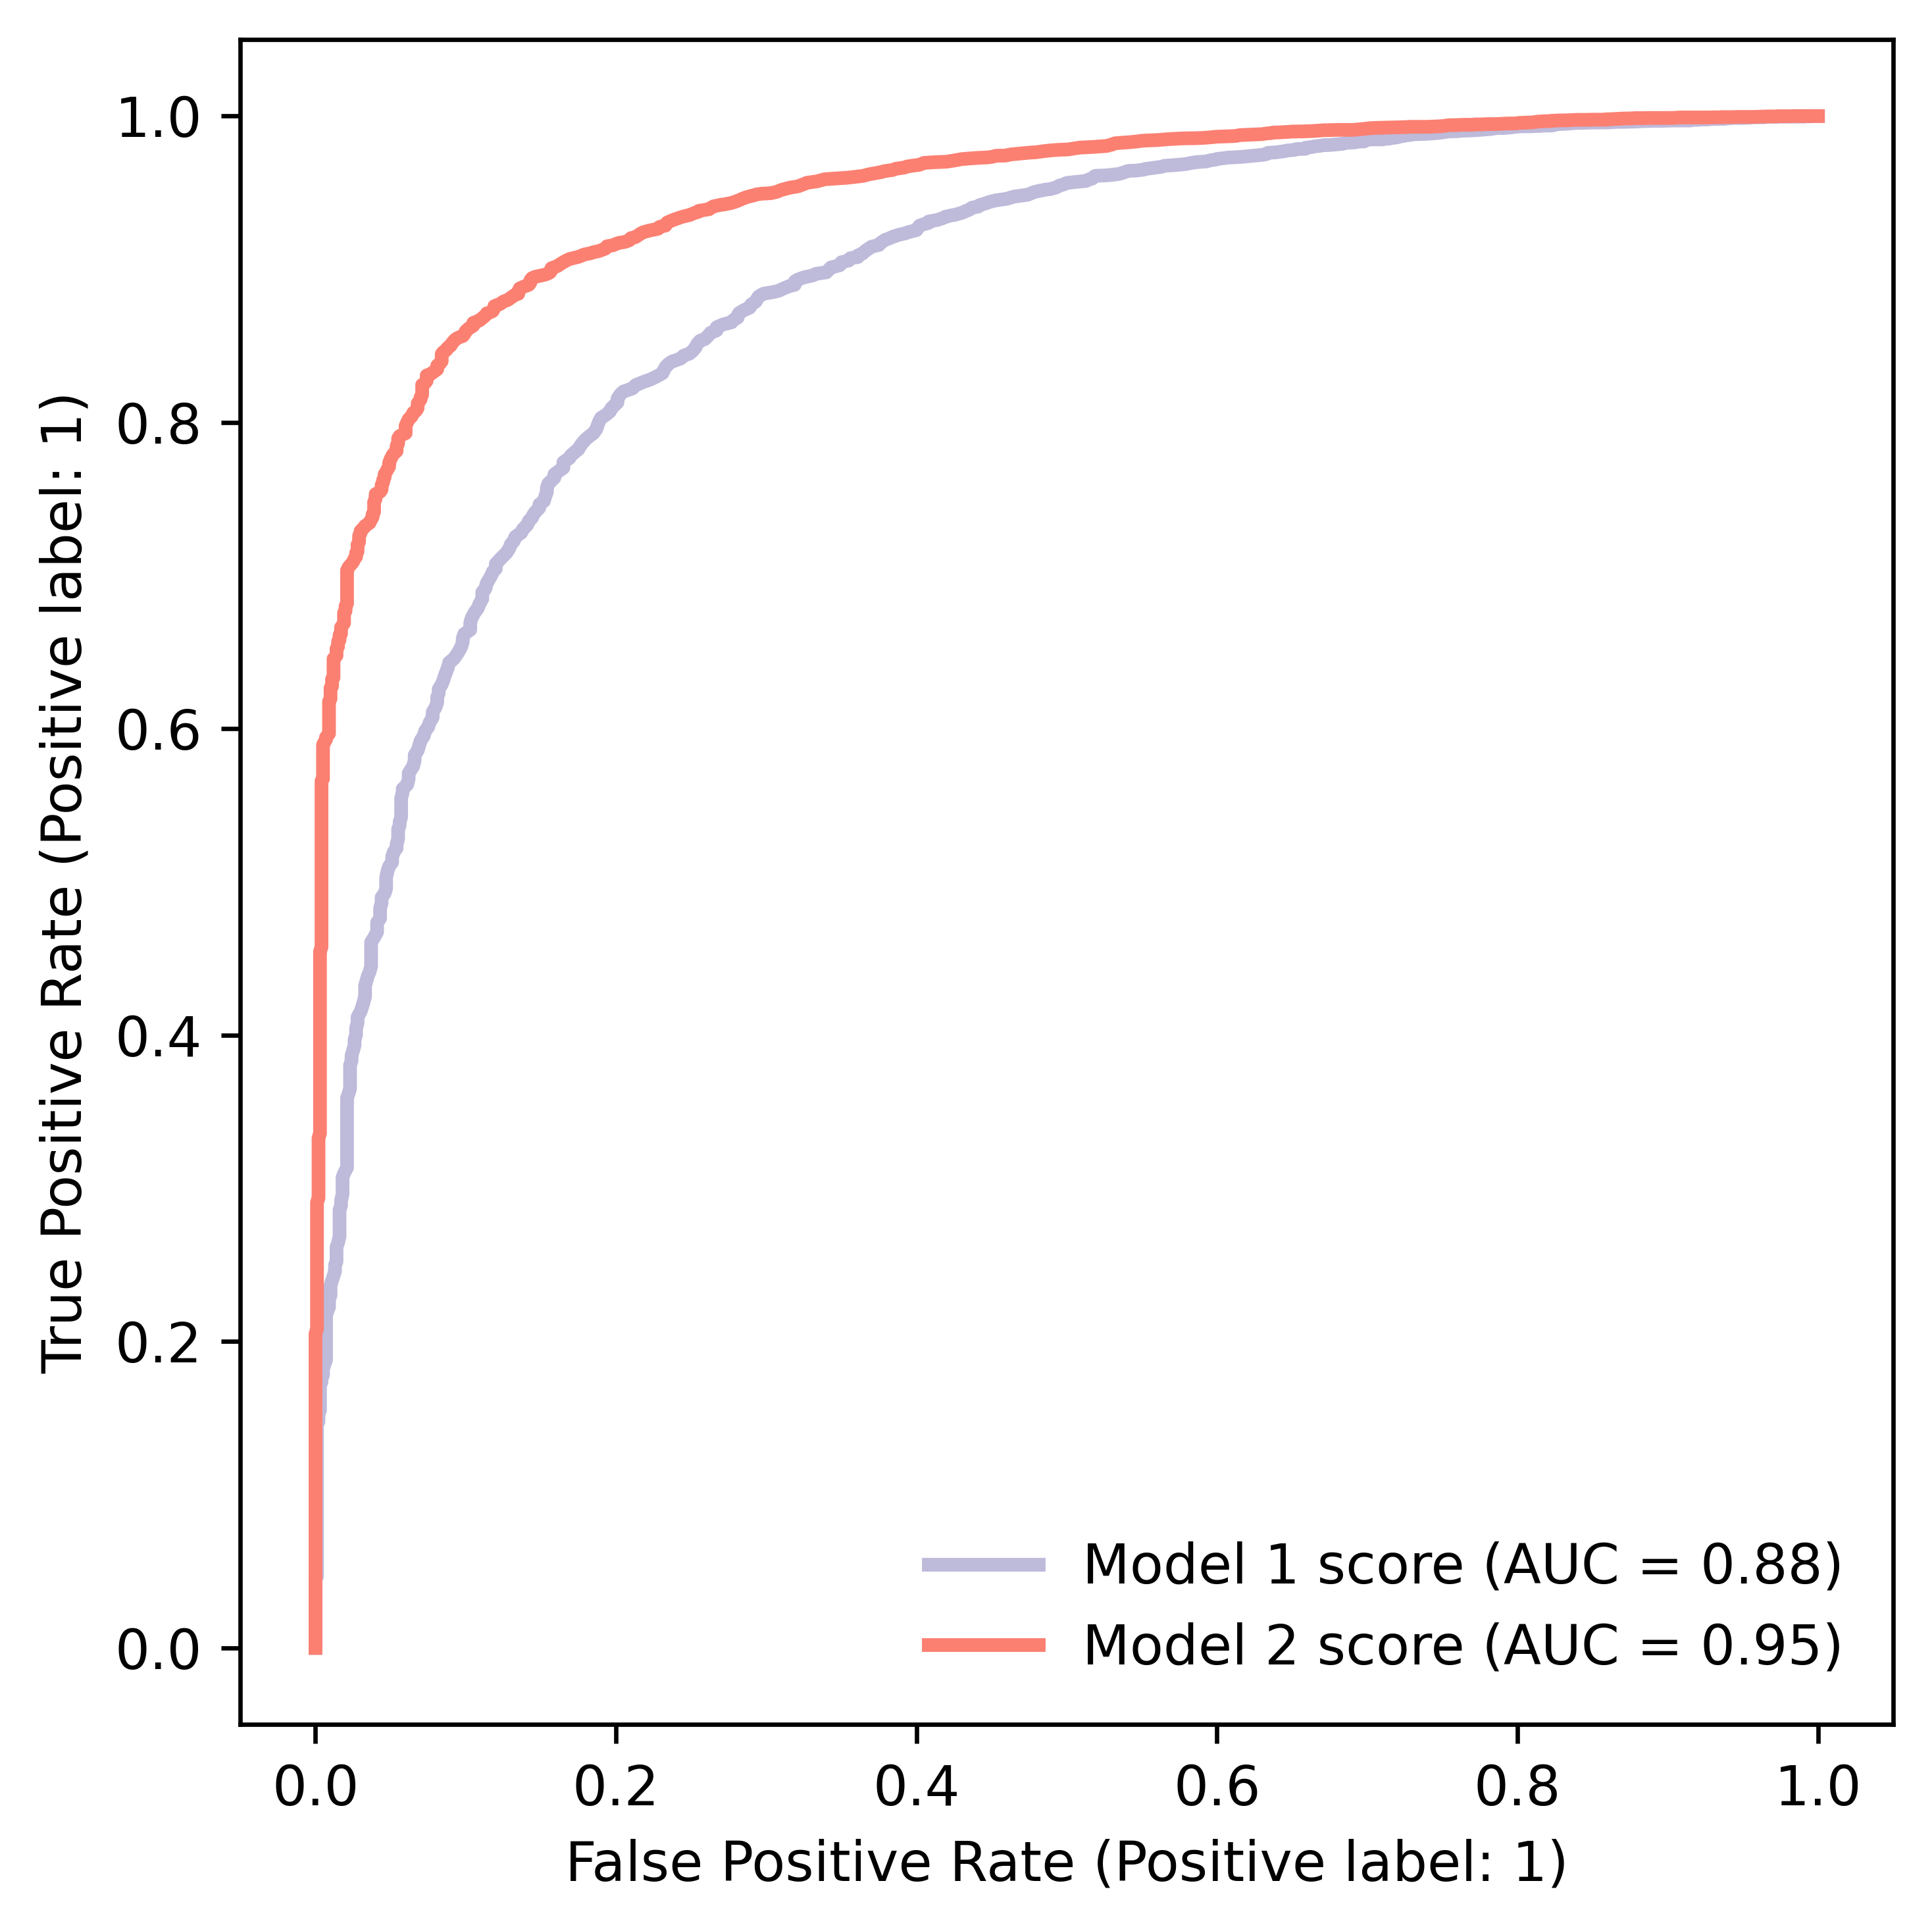

In [9]:
pred_list = [("Model 1 score", "model_1_score"), ("Model 2 score", "model_2_score")]

plt.figure(figsize=(5, 5), dpi=300)

ax_roc_auc_curve = plt.axes()
roc_auc_displays = {}
colors = plt.colormaps.get_cmap("Set3")

for i, (clf, name) in enumerate(pred_list):
    y_pred = dataset[name].values
    roc_auc_display = RocCurveDisplay.from_predictions(
        1 - dataset["is_bad"].values,
        y_pred,
        ax=ax_roc_auc_curve,
        name=clf,
        linewidth=2.5,
        color=colors(i + 2),
    )
    roc_auc_displays[name] = roc_auc_display

plt.legend(framealpha=0)
plt.tight_layout()

## Cut-off approach

In [10]:
# Specify scores
model_scores = ["model_1_score", "model_2_score"]
threshold_values = {}

for score_column in model_scores:
    FPRs, TPRs, thresholds = roc_curve(
        1 - dataset["is_bad"].values, dataset[score_column].values
    )
    df_thresholds = pd.DataFrame({"FPR": FPRs, "TPR": TPRs, "thresholds": thresholds})

    threshold_600 = df_thresholds[df_thresholds["thresholds"] == 600]
    threshold_values[score_column] = {
        "FPR": threshold_600["FPR"].values[0],
        "TPR": threshold_600["TPR"].values[0],
    }
    print(df_thresholds[df_thresholds["thresholds"] == 600])

       FPR       TPR  thresholds
204  0.021  0.345556       600.0
       FPR       TPR  thresholds
309  0.021  0.681667       600.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_34699/1807619504.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(
/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_34699/1807619504.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(


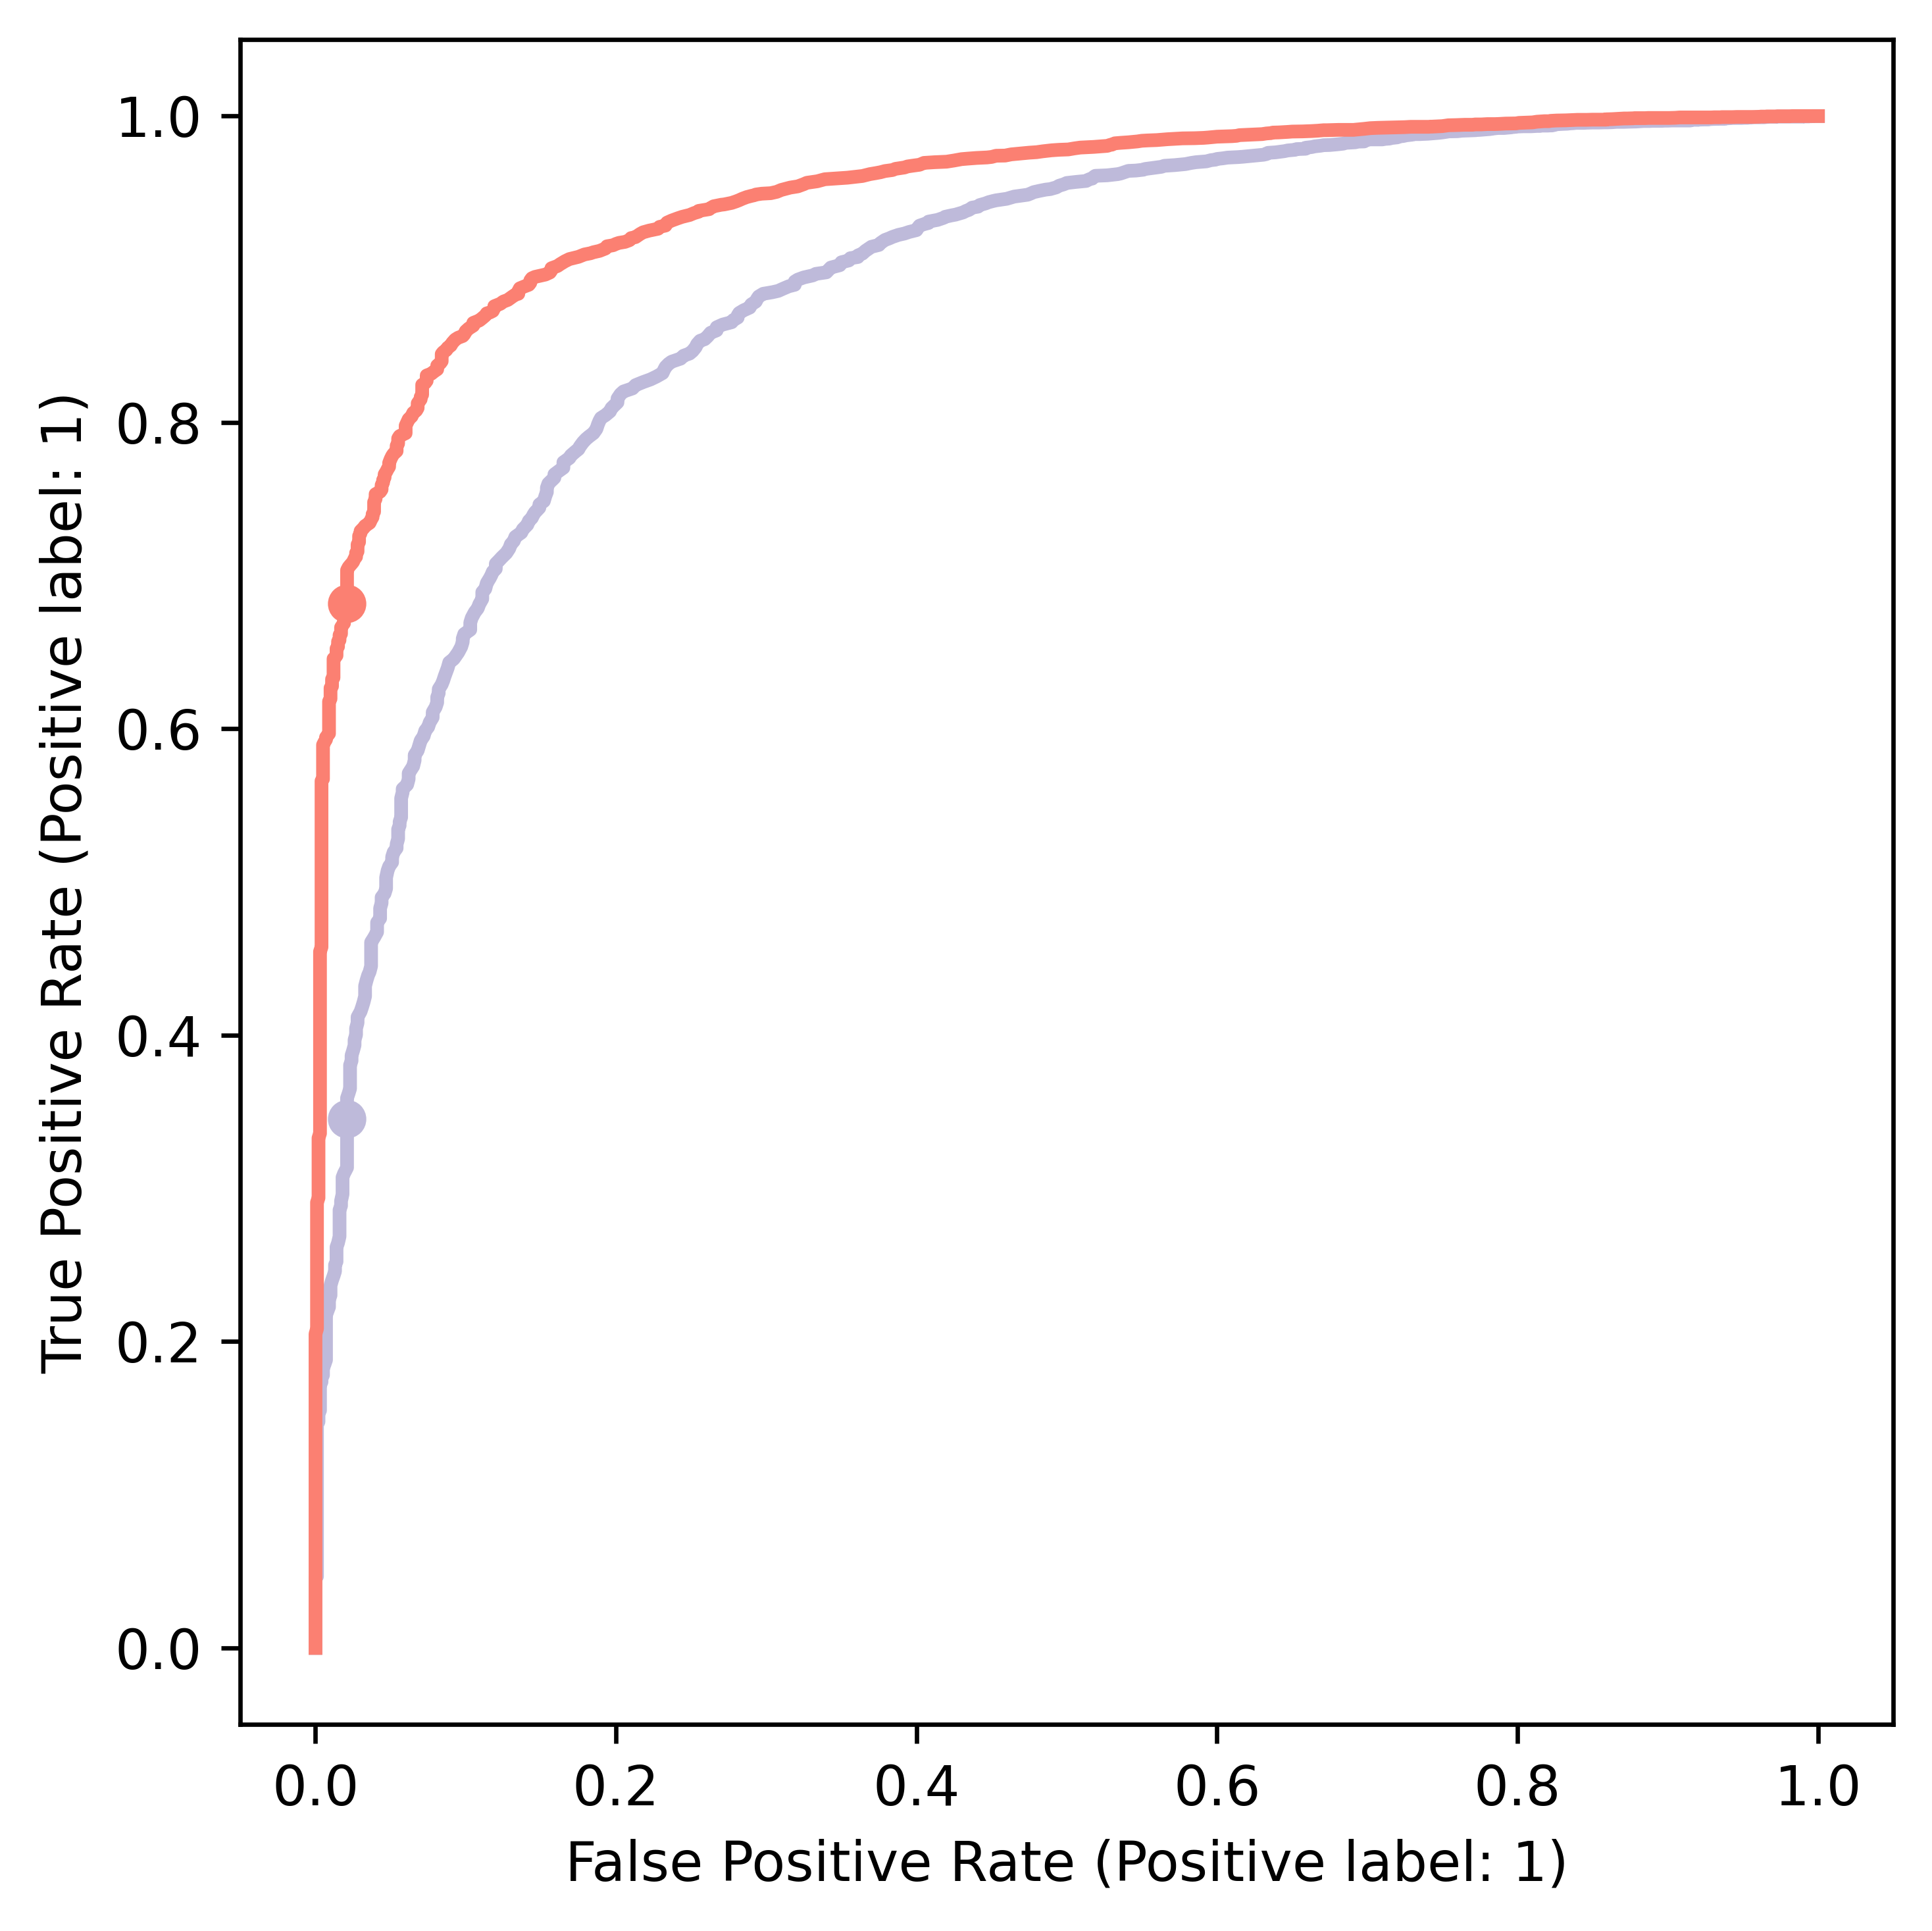

In [11]:
pred_list = [("Model 1 score", "model_1_score"), ("Model 2 score", "model_2_score")]

plt.figure(figsize=(5, 5), dpi=300)

ax_roc_auc_curve = plt.axes()
roc_auc_displays = {}
colors = plt.colormaps.get_cmap("Set3")

for i, (clf, name) in enumerate(pred_list):
    y_pred = dataset[name].values
    roc_auc_display = RocCurveDisplay.from_predictions(
        1 - dataset["is_bad"].values,
        y_pred,
        ax=ax_roc_auc_curve,
        name=clf,
        label=None,
        linewidth=2.5,
        color=colors(i + 2),
    )
    roc_auc_displays[name] = roc_auc_display

plt.legend(framealpha=0)

# Plot the cut-offs
plt.plot(
    threshold_values["model_1_score"]["FPR"],
    threshold_values["model_1_score"]["TPR"],
    "ro",
    color=colors(2),
    label="Model 1 score cut-off (600)",
)  # WOE = 600
plt.plot(
    threshold_values["model_2_score"]["FPR"],
    threshold_values["model_2_score"]["TPR"],
    "ro",
    color=colors(3),
    label="Model 2 score cut-off (600)",
)  # XGBoost = 600

plt.tight_layout()

We assume a score cut-off for approving a loan is at 600.

In [12]:
dataset[
    ["model_1_pd", "model_2_pd", "model_1_score", "model_2_score", "is_bad", "npv"]
].round(2).rename({"xgb_rf_score": "xgb_score"}, axis=1).sample(frac=0.3)[0:10]

,model_1_pd,model_2_pd,model_1_score,model_2_score,is_bad,npv
254,0.93,0.95,95.0,199.0,1,938.59
2535,0.05,0.01,494.0,740.0,0,2671.17
4358,0.02,0.01,557.0,790.0,0,1982.72
4323,0.01,0.07,643.0,497.0,0,284.89
4878,0.01,0.01,615.0,770.0,0,873.94
8782,0.08,0.01,466.0,708.0,0,2047.18
919,0.88,0.92,145.0,253.0,1,-6264.59
2859,0.16,0.01,406.0,688.0,0,594.70
3858,0.01,0.01,616.0,829.0,0,829.77
5833,0.00,0.00,709.0,855.0,0,4048.60


In [13]:
np.sum(np.where(dataset["model_1_score"] > 600, 1, 0)) / len(dataset), np.sum(
    np.where(dataset["model_2_score"] > 600, 1, 0)
) / len(dataset)

(0.3103, 0.6141)

In [14]:
# Define cut-offs
dataset["approved_model_1"] = np.where(dataset["model_1_score"] > 600, 1, 0)
dataset["approved_model_2"] = np.where(dataset["model_2_score"] > 600, 1, 0)

In [15]:
# NPV * approval
np.sum(dataset["approved_model_1"] * dataset["npv"]) / len(dataset), np.sum(
    dataset["approved_model_2"] * dataset["npv"]
) / len(dataset)

(716.3241114074381, 1486.4416930422353)

In [16]:
dataset[dataset["model_2_score"] < 600]["is_bad"].mean()

0.2546826222684703

### ROC Curve approach
First we need to treat non-defaulted class labels as approved. This means reversing the target variable.

In [17]:
y_pred_model_1 = 1 - dataset["model_1_pd"].values
y_pred_model_2 = 1 - dataset["model_2_pd"].values
y_true = 1 - dataset["is_bad"].values
npv_vector = dataset["npv"].values

In [18]:
def get_roc_curve_pnl(y_true, y_proba, npv_vector=None, delta=0.1):
    """
    Return the True Positive Rates (TPRs), False Positive Rates (FPRs),
    and the threshold values, seperated by delta.

    We reverse the thresholds because our label now means no default.
    We iterate from 1 to 0 to calculate the difference in NPVs for
    each threshold.
    """
    thresh = list(1 - np.arange(0, 1, delta)) + [0]
    TPRs = []
    FPRs = []
    PNL = []

    y_pred = np.empty(y_proba.shape)
    for th in thresh:
        y_pred[y_proba < th] = 0
        y_pred[y_proba >= th] = 1

        # confusion matrix
        (TN, FP), (FN, TP) = confusion_matrix(y_true, y_pred)
        TPR = TP / (TP + FN)  # sensitivity
        FPR = FP / (FP + TN)  # 1 - specificity
        TPRs.append(TPR)
        FPRs.append(FPR)

        PNL.append(np.sum(npv_vector * y_pred) / len(y_true))

    return PNL, thresh

In [19]:
pnl_roc_curve_1, thresholds_1 = get_roc_curve_pnl(
    y_true, y_pred_model_1, npv_vector=npv_vector, delta=0.1
)

pnl_roc_curve_2, thresholds_2 = get_roc_curve_pnl(
    y_true, y_pred_model_2, npv_vector=npv_vector, delta=0.1
)

In [20]:
pnl_data_model_1 = pd.DataFrame(pnl_roc_curve_1, columns=["model_1"])
pnl_data_model_2 = pd.DataFrame(pnl_roc_curve_2, columns=["model_2"])

delta_pnl_df = pnl_data_model_1.merge(
    pnl_data_model_2,
    left_index=True,
    suffixes=["_model_1", "_model_2"],
    right_index=True,
)

In [21]:
delta_pnl_df["pnl_effect"] = delta_pnl_df["model_2"] - delta_pnl_df["model_1"]

In [22]:
delta_pnl_df["threshold"] = thresholds_1

In [23]:
delta_pnl_df[["threshold", "model_1", "model_2", "pnl_effect"]].round(2)

,threshold,model_1,model_2,pnl_effect
0,1.0,0.00,0.00,0.00
1,0.9,1549.07,1781.71,232.64
2,0.8,1587.89,1823.16,235.27
3,0.7,1516.42,1788.79,272.37
4,0.6,1409.70,1718.61,308.90
5,0.5,1292.70,1580.72,288.01
6,0.4,1188.64,1481.78,293.13
7,0.3,1089.85,1353.02,263.17
8,0.2,998.98,1190.71,191.74
9,0.1,937.27,1033.62,96.34


In [24]:
(delta_pnl_df["pnl_effect"]).sum(), (delta_pnl_df["model_1"]).sum(), (
    delta_pnl_df["model_2"]
).sum()

(2181.5891376778636, 12482.150282503133, 14663.739420180995)

In [25]:
dataset["npv"].sum() / len(dataset)

911.6168596461298